In [1]:
import pandas as pd
import glob
import os

# Set the folder path where your CSV files are stored
folder_path = 'data/output_poses_with_c'  # Adjust if your files are elsewhere

# Get a list of all CSV files in the folder
csv_files = glob.glob(os.path.join(folder_path, '*.csv'))

# Load and concatenate all CSV files into one DataFrame
df_list = []
for file in csv_files:
    df = pd.read_csv(file)
    df['source_file'] = os.path.basename(file)  # Optionally add a column to track source
    df_list.append(df)

all_videos_df = pd.concat(df_list, ignore_index=True)

# Show the first few rows to confirm it worked
print(all_videos_df.head())

# Optionally, save combined DataFrame for later use
# all_videos_df.to_csv('/mnt/data/all_videos_combined.csv', index=False)


   FrameNo  head_x  head_y  head_confidence  left_shoulder_x  left_shoulder_y  \
0        0     995     389         0.557739             1059              450   
1        1     993     389         0.587303             1057              450   
2        2     990     389         0.598732             1057              450   
3        3     988     388         0.613654             1055              452   
4        4     988     388         0.622426             1056              452   

   left_shoulder_confidence  right_shoulder_x  right_shoulder_y  \
0                  0.560603               913               444   
1                  0.557815               913               444   
2                  0.565982               914               444   
3                  0.531750               913               443   
4                  0.534323               916               444   

   right_shoulder_confidence  ...  right_knee_x  right_knee_y  \
0                   0.464795  ...           9

In [18]:
"""
Lowest-confidence pose-sequence finder
• Optional middle-trim
• Full non-overlapping windows only
• Outputs original frame numbers *and* wall-clock time stamps
"""

import pandas as pd
import glob, os, math
from collections import defaultdict

# ─── USER SETTINGS ─────────────────────────────────────────────────────────────
folder_path     = "data/output_poses_with_c"   # where the *.csv live
fps             = 15            # frames per second in the original videos
window_size     = 15            # non-overlapping window size (frames)
list_length     = 200            # total sequences to list
max_per_video   = 1             # cap sequences per individual video
keep_frames     = 45            # keep this many middle frames (None → no trim)
conf_suffix     = "_confidence" # column-name suffix for confidences
# ───────────────────────────────────────────────────────────────────────────────

def fmt_time(sec: float) -> str:
    """Convert decimal seconds to HH:MM:SS (zero-padded, no fractions)."""
    sec = int(round(sec))
    h, m = divmod(sec, 3600)
    m, s = divmod(m, 60)
    return f"{h:02d}:{m:02d}:{s:02d}"

csv_files = glob.glob(os.path.join(folder_path, "*.csv"))
if not csv_files:
    raise FileNotFoundError(f"No CSV files found in {folder_path}")

all_windows = []

for path in csv_files:
    df        = pd.read_csv(path)
    filename  = os.path.basename(path)
    n_total   = len(df)

    # ── Trim to middle `keep_frames` if requested ────────────────────────────
    if keep_frames and keep_frames < n_total:
        trim_left  = (n_total - keep_frames) // 2          # floor
        trim_right = n_total - keep_frames - trim_left     # may be +1
        df_trimmed = df.iloc[trim_left : n_total - trim_right].reset_index(drop=True)
    else:
        trim_left  = 0
        df_trimmed = df.copy()

    n_frames = len(df_trimmed)

    # Identify confidence columns
    conf_cols = [c for c in df_trimmed.columns if c.lower().endswith(conf_suffix)]
    if not conf_cols:
        raise ValueError(f"No “{conf_suffix}” columns in {filename}")

    # ── Iterate through *full* non-overlapping windows ───────────────────────
    n_full_windows = n_frames // window_size
    for w in range(n_full_windows):
        start_trim = w * window_size               # 0-based in trimmed clip
        end_trim   = start_trim + window_size      # exclusive
        window     = df_trimmed.iloc[start_trim:end_trim]

        means       = window[conf_cols].mean()
        worst_col   = means.idxmin()
        worst_joint = worst_col.replace(conf_suffix, "")
        worst_val   = means[worst_col]

        # Translate to original frame indices (1-based, inclusive)
        orig_start = trim_left + start_trim + 1
        orig_end   = trim_left + end_trim          # inclusive

        all_windows.append(
            {
                "filename":     filename,
                "orig_start":   orig_start,
                "orig_end":     orig_end,
                "joint":        worst_joint,
                "avg_conf":     worst_val,
                "t_start":      (orig_start - 1) / fps,
                "t_end":        (orig_end   - 1) / fps,
            }
        )

# ─── Global ranking & output limits ───────────────────────────────────────────
all_windows.sort(key=lambda w: w["avg_conf"])          # worst first
selected, per_video = [], defaultdict(int)

for w in all_windows:
    if per_video[w["filename"]] < max_per_video:
        selected.append(w)
        per_video[w["filename"]] += 1
    if len(selected) >= list_length:
        break

# ─── Report ───────────────────────────────────────────────────────────────────
print("\nWorst sequences found (original timeline):\n")
for w in selected:
    print(
        f"{w['filename']}  frames {w['orig_start']}–{w['orig_end']}  "
        f"from {fmt_time(w['t_start'])} to {fmt_time(w['t_end'])}  "
        f"– confidence of the {w['joint']} is {w['avg_conf']:.2f}"
    )



Worst sequences found (original timeline):

W25.csv  frames 108–122  from 00:00:07 to 00:00:08  – confidence of the left_foot is 0.13
W31.csv  frames 105–119  from 00:00:07 to 00:00:08  – confidence of the right_foot is 0.14
W24.csv  frames 100–114  from 00:00:07 to 00:00:08  – confidence of the left_knee is 0.15
W34.csv  frames 103–117  from 00:00:07 to 00:00:08  – confidence of the left_foot is 0.16
W09.csv  frames 102–116  from 00:00:07 to 00:00:08  – confidence of the right_foot is 0.16
G73.csv  frames 156–170  from 00:00:10 to 00:00:11  – confidence of the right_hand is 0.17
G04.csv  frames 118–132  from 00:00:08 to 00:00:09  – confidence of the right_hand is 0.17
G38.csv  frames 127–141  from 00:00:08 to 00:00:09  – confidence of the right_elbow is 0.17
G28.csv  frames 99–113  from 00:00:07 to 00:00:07  – confidence of the right_hand is 0.17
G05.csv  frames 102–116  from 00:00:07 to 00:00:08  – confidence of the right_hand is 0.18
W18.csv  frames 101–115  from 00:00:07 to 00:00:

In [17]:
"""
Highest-confidence pose-sequence finder
• Optional middle-trim
• Full non-overlapping windows only
• Reports original frame numbers and wall-clock time stamps
• NOW: shows the joint with the HIGHEST confidence in each window
"""

import pandas as pd
import glob, os
from collections import defaultdict

# ─── USER SETTINGS ────────────────────────────────────────────────────────────
folder_path     = "data/output_poses_with_c"   # where the *.csv live
fps             = 15            # frames per second in the original videos
window_size     = 10            # non-overlapping window size (frames)
list_length     = 200           # total sequences to list
max_per_video   = 1             # cap sequences per individual video
keep_frames     = 40            # keep this many middle frames (None → no trim)
conf_suffix     = "_confidence" # column-name suffix for confidences
# ──────────────────────────────────────────────────────────────────────────────

def fmt_time(sec: float) -> str:
    """Convert decimal seconds to HH:MM:SS."""
    sec = int(round(sec))
    h, m = divmod(sec, 3600)
    m, s = divmod(m, 60)
    return f"{h:02d}:{m:02d}:{s:02d}"

csv_files = glob.glob(os.path.join(folder_path, "*.csv"))
if not csv_files:
    raise FileNotFoundError(f"No CSV files found in {folder_path}")

all_windows = []

for path in csv_files:
    df        = pd.read_csv(path)
    filename  = os.path.basename(path)
    n_total   = len(df)

    # ── Trim to the middle `keep_frames` frames if requested ────────────────
    if keep_frames and keep_frames < n_total:
        trim_left  = (n_total - keep_frames) // 2
        trim_right = n_total - keep_frames - trim_left
        df_trimmed = df.iloc[trim_left : n_total - trim_right].reset_index(drop=True)
    else:
        trim_left  = 0
        df_trimmed = df.copy()

    n_frames   = len(df_trimmed)
    conf_cols  = [c for c in df_trimmed.columns if c.lower().endswith(conf_suffix)]
    if not conf_cols:
        raise ValueError(f"No “{conf_suffix}” columns in {filename}")

    # ── Full, non-overlapping windows ───────────────────────────────────────
    n_full_windows = n_frames // window_size
    for w in range(n_full_windows):
        start_t   = w * window_size
        end_t     = start_t + window_size
        window    = df_trimmed.iloc[start_t:end_t]

        means       = window[conf_cols].mean()
        best_col    = means.idxmax()               # ← change 1 (idxmax, not idxmin)
        best_joint  = best_col.replace(conf_suffix, "")
        best_val    = means[best_col]              # highest = best

        orig_start  = trim_left + start_t + 1      # 1-based inclusive
        orig_end    = trim_left + end_t

        all_windows.append(
            {
                "filename":   filename,
                "orig_start": orig_start,
                "orig_end":   orig_end,
                "joint":      best_joint,
                "avg_conf":   best_val,
                "t_start":    (orig_start - 1) / fps,
                "t_end":      (orig_end   - 1) / fps,
            }
        )

# ─── Rank by *highest* joint confidence ──────────────────────────────────────
all_windows.sort(key=lambda w: w["avg_conf"], reverse=True)  # ← change 2
selected, per_video = [], defaultdict(int)

for w in all_windows:
    if per_video[w["filename"]] < max_per_video:
        selected.append(w)
        per_video[w["filename"]] += 1
    if len(selected) >= list_length:
        break

# ─── Report ──────────────────────────────────────────────────────────────────
print("\nBest sequences found (original timeline):\n")
for w in selected:
    print(
        f"{w['filename']}  frames {w['orig_start']}–{w['orig_end']}  "
        f"from {fmt_time(w['t_start'])} to {fmt_time(w['t_end'])}  "
        f"– confidence of the {w['joint']} is {w['avg_conf']:.2f}"
    )



Best sequences found (original timeline):

W08.csv  frames 107–116  from 00:00:07 to 00:00:08  – confidence of the right_hip is 0.79
W29.csv  frames 113–122  from 00:00:07 to 00:00:08  – confidence of the left_hip is 0.75
W06.csv  frames 86–95  from 00:00:06 to 00:00:06  – confidence of the right_shoulder is 0.74
W37.csv  frames 70–79  from 00:00:05 to 00:00:05  – confidence of the left_hip is 0.74
W20.csv  frames 65–74  from 00:00:04 to 00:00:05  – confidence of the right_knee is 0.74
W07.csv  frames 79–88  from 00:00:05 to 00:00:06  – confidence of the right_shoulder is 0.74
G71.csv  frames 239–248  from 00:00:16 to 00:00:16  – confidence of the right_hip is 0.73
W19.csv  frames 60–69  from 00:00:04 to 00:00:05  – confidence of the left_hip is 0.73
G28.csv  frames 92–101  from 00:00:06 to 00:00:07  – confidence of the right_knee is 0.72
G72.csv  frames 261–270  from 00:00:17 to 00:00:18  – confidence of the right_hip is 0.72
W42.csv  frames 95–104  from 00:00:06 to 00:00:07  – confi

FrameNo,
left_shoulder,left_elbow,left_hand, left_hip,left_knee,left_foot,
right_shoulder,right_elbow,right_hand, right_hip,right_knee,right_foot,








Worst sequences found (block averages, original timeline):

W34.csv  frames 95–104  from 00:00:06 to 00:00:07  – block bottom_right average confidence 0.18
W21.csv  frames 59–68  from 00:00:04 to 00:00:04  – block bottom_right average confidence 0.23
W28.csv  frames 47–56  from 00:00:03 to 00:00:04  – block bottom_left average confidence 0.23
W31.csv  frames 107–116  from 00:00:07 to 00:00:08  – block bottom_right average confidence 0.25
W28.csv  frames 57–66  from 00:00:04 to 00:00:04  – block bottom_left average confidence 0.25
W36.csv  frames 111–120  from 00:00:07 to 00:00:08  – block bottom_left average confidence 0.25
W36.csv  frames 121–130  from 00:00:08 to 00:00:09  – block top_left average confidence 0.25
W34.csv  frames 105–114  from 00:00:07 to 00:00:08  – block bottom_right average confidence 0.25
W36.csv  frames 91–100  from 00:00:06 to 00:00:07  – block bottom_left average confidence 0.25
W36.csv  frames 101–110  from 00:00:07 to 00:00:07  – block bottom_right average c

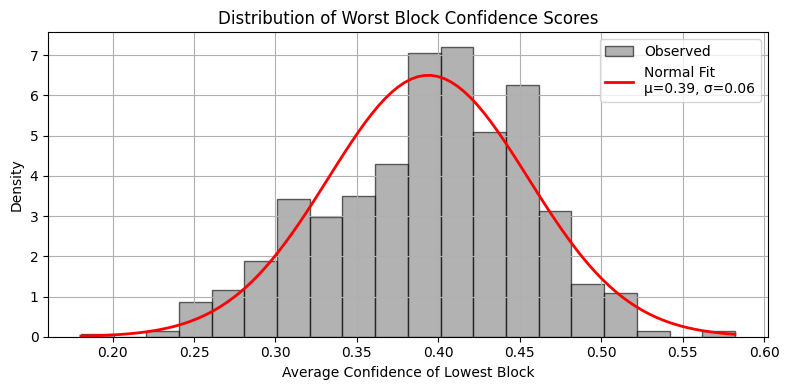


Saved 684 rows to convedence_10.csv



In [30]:
"""
Lowest-confidence pose-sequence finder  (block version)
• Optional middle-trim
• Full non-overlapping windows
• Works with four body blocks (head excluded)
• Reports original frame numbers & hh:mm:ss timeline
"""

import pandas as pd
import glob, os
from collections import defaultdict

# ─── USER SETTINGS ────────────────────────────────────────────────────────────
folder_path   = "data/output_poses_with_c"  # where the CSVs live
fps           = 15        # frames per second
window_size   = 10        # frames per window (non-overlapping)
list_length   = 5000       # total windows to list
max_per_video = 6         # cap windows per individual video
keep_frames   = 60        # keep this many middle frames (None → no trim)
conf_suffix   = "_confidence"
# ──────────────────────────────────────────────────────────────────────────────

# Map block label → list of confidence column names
BLOCKS = {
    "top_left":    ["left_shoulder_confidence",  "left_elbow_confidence",
                    "left_hand_confidence"],
    "bottom_left": ["left_hip_confidence",       "left_knee_confidence",
                    "left_foot_confidence"],
    "top_right":   ["right_shoulder_confidence", "right_elbow_confidence",
                    "right_hand_confidence"],
    "bottom_right":["right_hip_confidence",      "right_knee_confidence",
                    "right_foot_confidence"],
}

def fmt_time(sec: float) -> str:
    sec = int(round(sec))
    h, m = divmod(sec, 3600)
    m, s = divmod(m, 60)
    return f"{h:02d}:{m:02d}:{s:02d}"

csv_files = glob.glob(os.path.join(folder_path, "*.csv"))
if not csv_files:
    raise FileNotFoundError(f"No CSV files found in {folder_path}")

all_windows = []

for path in csv_files:
    df        = pd.read_csv(path)
    filename  = os.path.basename(path)
    n_total   = len(df)

    # ── optional middle trim ────────────────────────────────────────────────
    if keep_frames and keep_frames < n_total:
        cut_left  = (n_total - keep_frames) // 2
        cut_right = n_total - keep_frames - cut_left
        df_trim   = df.iloc[cut_left : n_total - cut_right].reset_index(drop=True)
    else:
        cut_left  = 0
        df_trim   = df.copy()

    n_frames = len(df_trim)
    # quick sanity: make sure every required column is present
    for cols in BLOCKS.values():
        missing = [c for c in cols if c not in df_trim.columns]
        if missing:
            raise ValueError(f"{filename} lacks columns: {missing}")

    # ── full, non-overlapping windows ───────────────────────────────────────
    for w in range(n_frames // window_size):
        s  = w * window_size
        e  = s + window_size     # exclusive
        win = df_trim.iloc[s:e]

        # block averages for this window
        block_avg = {
            label: win[cols].mean().mean()     # mean over frames then joints
            for label, cols in BLOCKS.items()
        }

        worst_label = min(block_avg, key=block_avg.get)
        worst_val   = block_avg[worst_label]

        orig_start = cut_left + s + 1     # 1-based inclusive
        orig_end   = cut_left + e         # inclusive

        all_windows.append(
            {
                "filename":   filename,
                "orig_start": orig_start,
                "orig_end":   orig_end,
                "block":      worst_label,
                "avg_conf":   worst_val,
                "t_start":    (orig_start - 1) / fps,
                "t_end":      (orig_end   - 1) / fps,
            }
        )

# ─── rank & limit output ─────────────────────────────────────────────────────
all_windows.sort(key=lambda w: w["avg_conf"])  # smallest first  (worst)
selected, per_video = [], defaultdict(int)

for w in all_windows:
    if per_video[w["filename"]] < max_per_video:
        selected.append(w)
        per_video[w["filename"]] += 1
    if len(selected) >= list_length:
        break

# ─── report ──────────────────────────────────────────────────────────────────
print("\nWorst sequences found (block averages, original timeline):\n")
for w in selected:
    print(
        f"{w['filename']}  frames {w['orig_start']}–{w['orig_end']}  "
        f"from {fmt_time(w['t_start'])} to {fmt_time(w['t_end'])}  "
        f"– block {w['block']} average confidence {w['avg_conf']:.2f}"
    )
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

# Extract confidence scores from the selected windows
confidences = [w["avg_conf"] for w in selected]

# Fit a normal distribution
mu, std = norm.fit(confidences)

# Generate x-values across the range
x = np.linspace(min(confidences), max(confidences), 100)
pdf = norm.pdf(x, mu, std)

# Plot histogram and fitted normal curve
plt.figure(figsize=(8, 4))
plt.hist(confidences, bins=20, density=True, alpha=0.6, color='gray', edgecolor='black', label='Observed')
plt.plot(x, pdf, 'r-', linewidth=2, label=f'Normal Fit\nμ={mu:.2f}, σ={std:.2f}')
plt.title("Distribution of Worst Block Confidence Scores")
plt.xlabel("Average Confidence of Lowest Block")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
# ─── save results to CSV ──────────────────────────────────────────────────────
if selected:
    out = pd.DataFrame(selected)
    # add hh:mm:ss strings for convenience
    out["t_start_hms"] = out["t_start"].apply(fmt_time)
    out["t_end_hms"]   = out["t_end"].apply(fmt_time)

    output_fname = f"convedence_{window_size}.csv"
    out.to_csv(output_fname, index=False)
    print(f"\nSaved {len(out)} rows to {output_fname}\n")
else:
    print("\nNo windows met the selection criteria – nothing saved.\n")
